In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
track_metadata_df = pd.read_csv('song_data.csv')
count_play_df = pd.read_csv('playcount.txt', sep='\t', header=None, names=['user','song','play_count'])

print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
display(count_play_df.shape, count_play_df.head())

First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Note the problem with repeated track metadata. Let's see of counts play song by users:


(2000000, 3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


So, as we expect, before go forward first we need take care of the repeated track metadata. Since most of the case are nulls and some cases are divergent values, we will substitute all inconsistencies by their respective max value by each song Id.

In [5]:
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
display(unique_track_metadata_df.head())

Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


Then we need merge the two datasets based on the songs ids.

In [6]:
user_song_list_count = pd.merge(count_play_df, 
                                unique_track_metadata_df, how='left', 
                                left_on='song', 
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])

# Exploratory Data Analysis (EDA)

In [7]:
display(user_song_list_count.head())
user_song_list_count.listen_count.describe().reset_index().T

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2000000.0,3.045485,6.57972,1.0,1.0,1.0,3.0,2213.0


Hum, it looks like we have some users obsessed with a single song! A user having heard 2,213 times a single song is something very extreme considering that we have only 3 times in the third quartile. Let's check how many users listen to a single song more than 3 times and more than 200 times.

In [8]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)

118 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140.0,327.107143,209.11467,201.0,225.0,267.0,353.75,2213.0


Let's consider that a song has 3:30 minutes in average and create it for the two most obsessed users and check out what their songs are:

In [9]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song.values)])

- How much days the most obsessed user can be the fan of a unique song: 5.4


,song_id,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


In [10]:
obsessed = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-1500].values[1]
print('- How much days the second obsessed user can be the fan of a unique song: {:.1f}'.format((obsessed*3)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(count_play_df[count_play_df.play_count==920].song.values)])

- How much days the second obsessed user can be the fan of a unique song: 1.9


,song_id,title,release,artist_name,year
927746,SOUAGPQ12A8AE47B3A,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998


Taste is not discussed, but regrets!

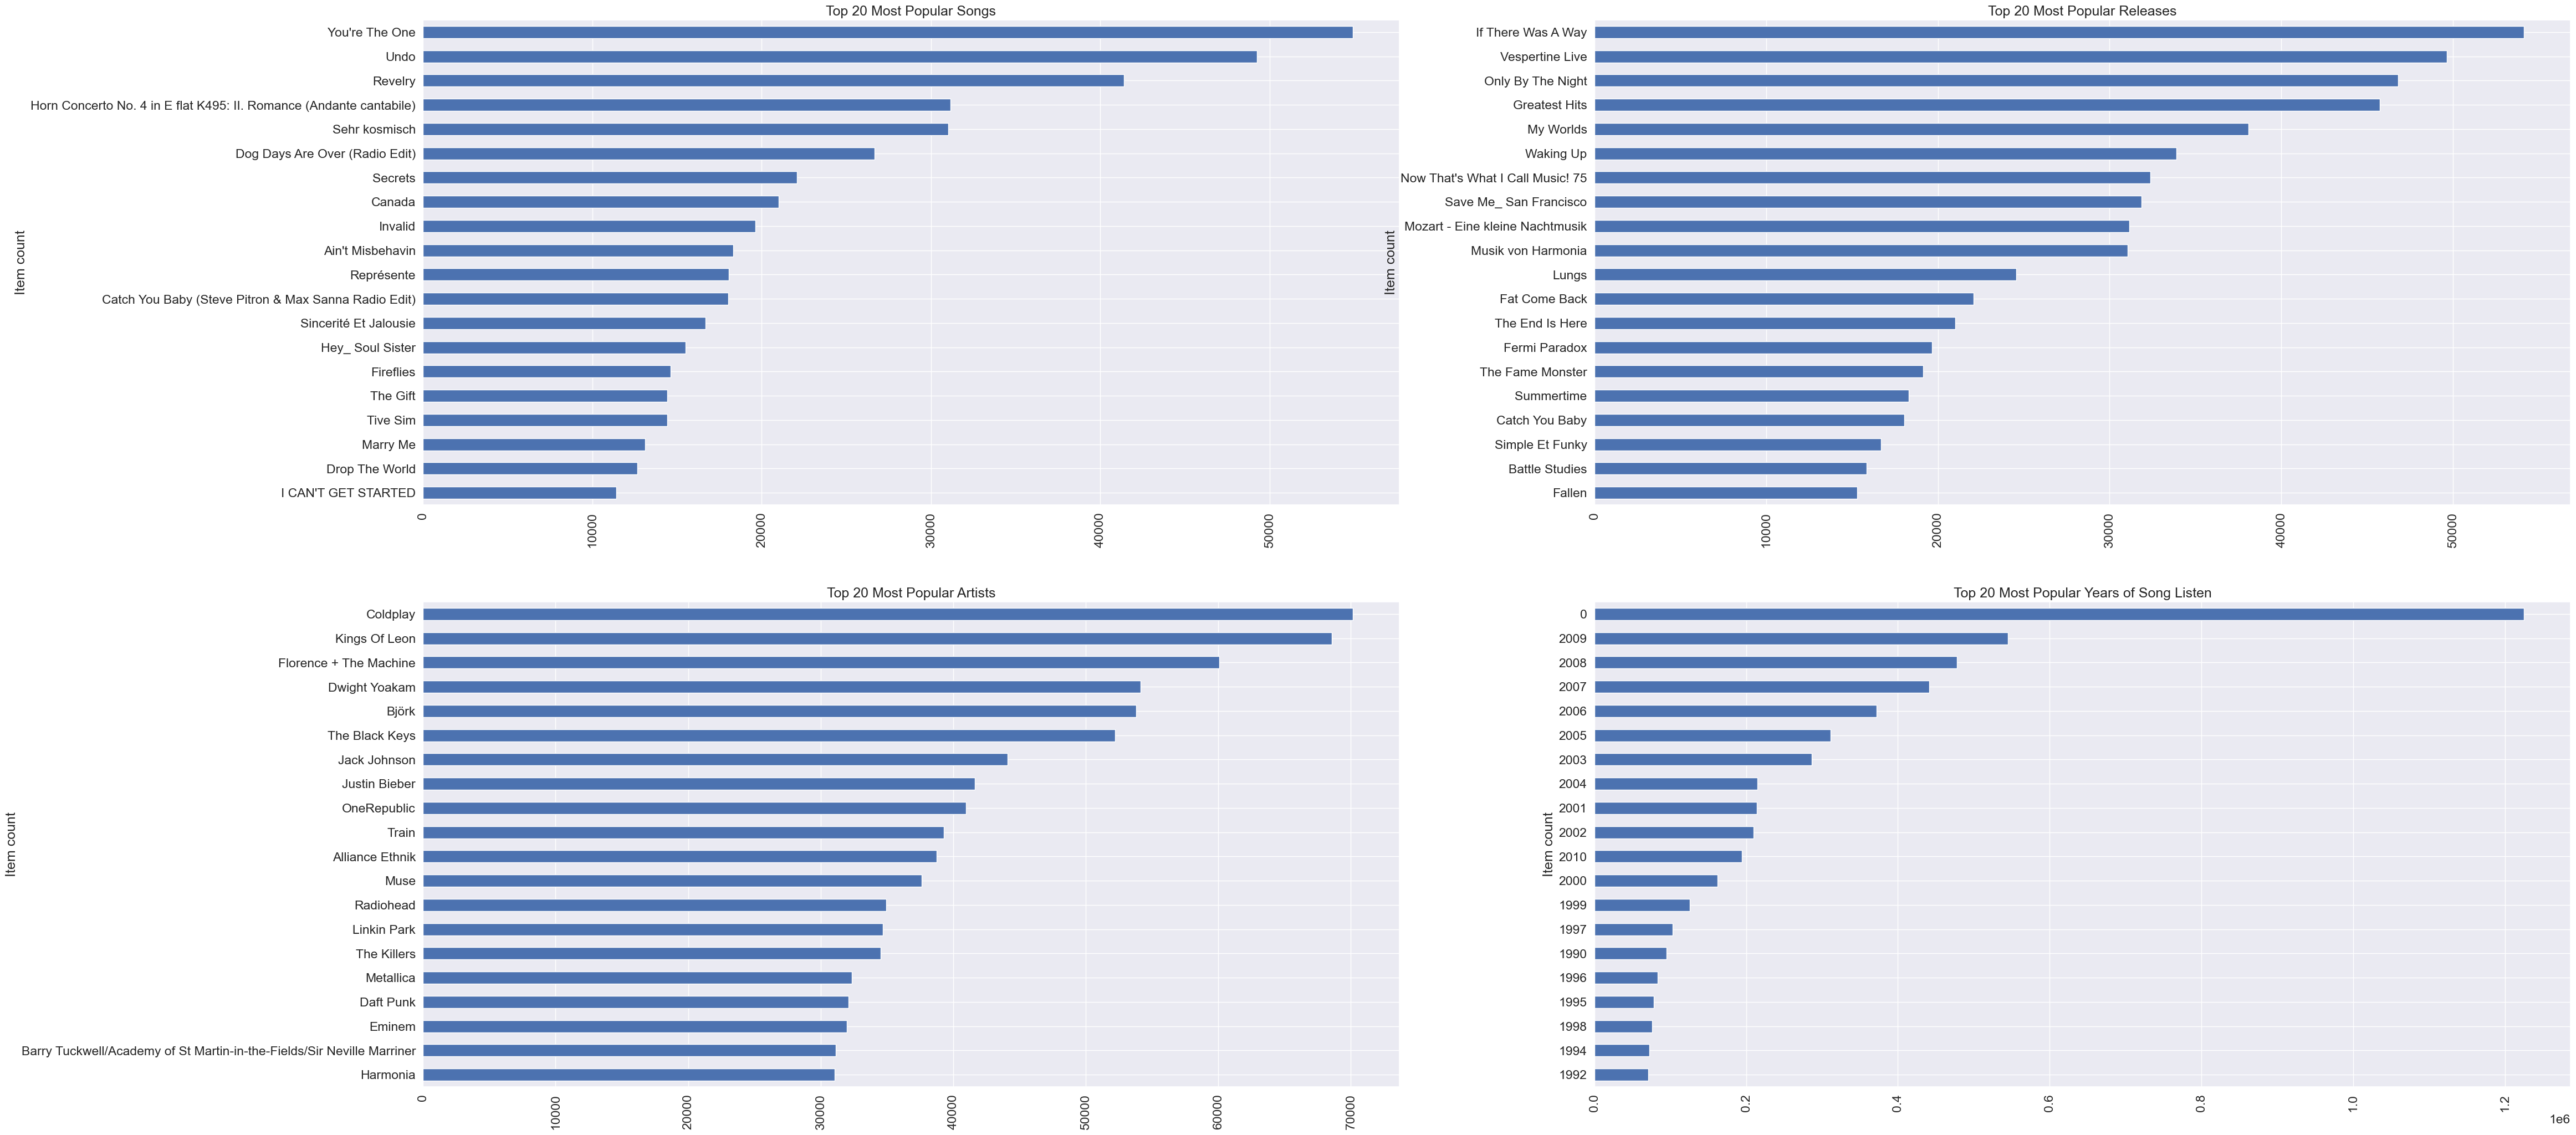

In [11]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

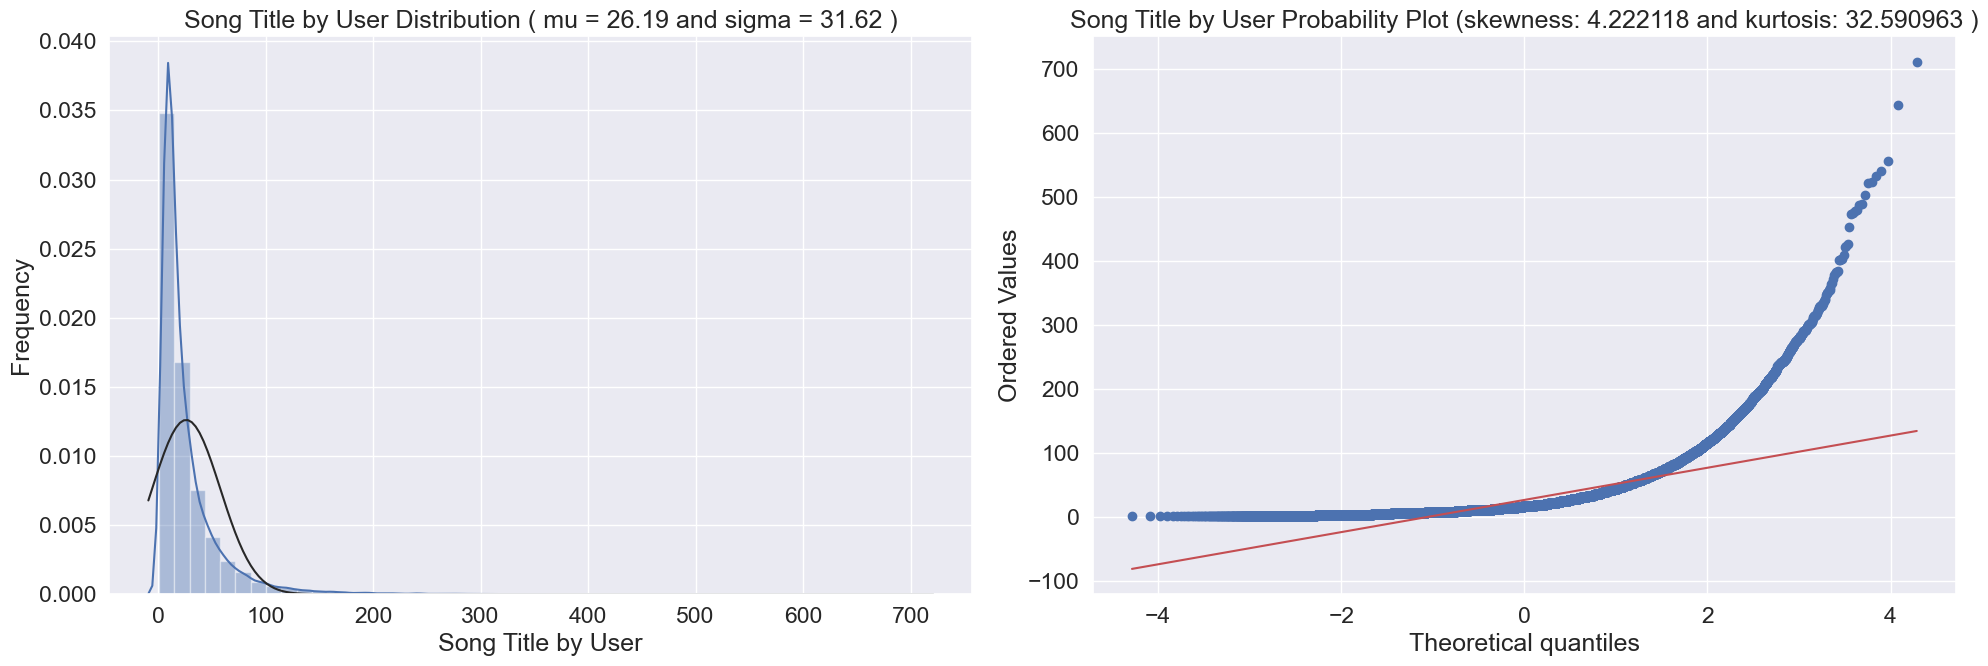

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,76353.0,26.194125,31.625078,1.0,9.0,16.0,31.0,711.0


In [13]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

#Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 32.6 of positive kurtosis song title by user are heavy-tailed and definitely has outliers.

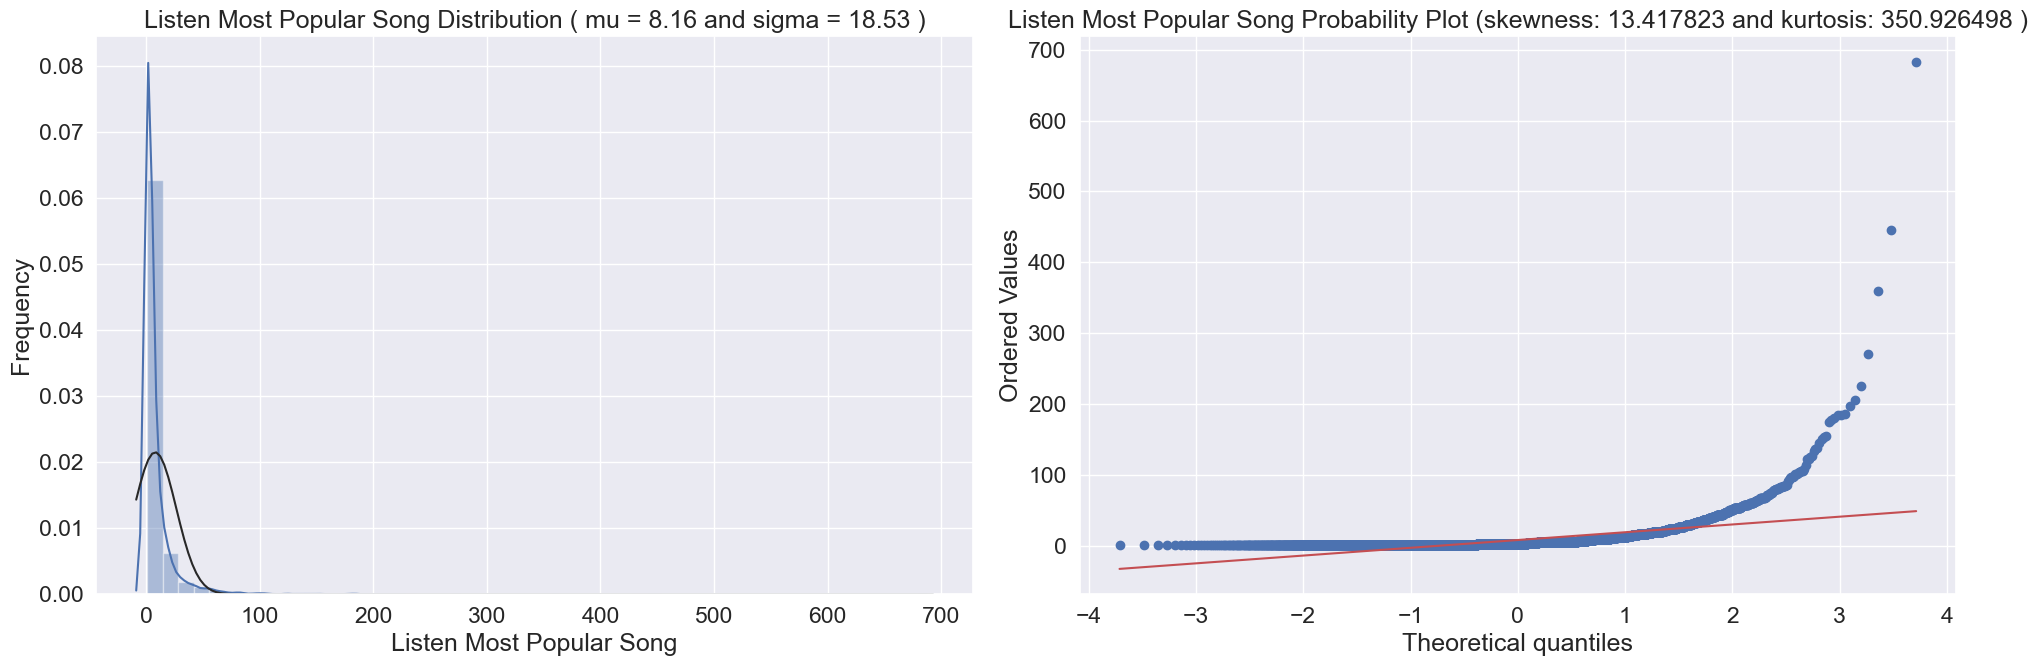

In [14]:
QQ_plot(user_song_list_count[user_song_list_count.title=="You're The One"].listen_count, 'Listen Most Popular Song')

In [15]:
def create_popularity_recommendation(train_data, user_id, item_id, n=10):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort.score.rank(ascending=0, method='first')
    
      #Get the top n recommendations
    popularity_recommendations = train_data_sort.head(n)
    return popularity_recommendations

In [16]:
recommendations = create_popularity_recommendation(user_song_list_count,'user','title', 15)
display(recommendations)

,title,score,Rank
6837,Sehr kosmisch,8277,1.0
8726,Undo,7032,2.0
1965,Dog Days Are Over (Radio Edit),6949,3.0
9497,You're The One,6729,4.0
6499,Revelry,6145,5.0
6826,Secrets,5841,6.0
3438,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,7.0
2596,Fireflies,4795,8.0
3323,Hey_ Soul Sister,4758,9.0
8495,Tive Sim,4548,10.0


We can use our popularity recommendation function to find the 10 artists recommendations too.

In [17]:
display(create_popularity_recommendation(user_song_list_count,'user','artist_name', 10)) 

,artist_name,score,Rank
649,Coldplay,29422,1.0
2850,The Black Keys,19862,2.0
1651,Kings Of Leon,18747,3.0
1107,Florence + The Machine,18112,4.0
1370,Jack Johnson,17801,5.0
2946,The Killers,16063,6.0
2374,Radiohead,14890,7.0
736,Daft Punk,14715,8.0
2073,Muse,14005,9.0
1554,Justin Bieber,13959,10.0


# Item Similarity Based Recommendation Engine

In [18]:
total_play_count = sum(user_song_list_count.listen_count)
play_count = user_song_list_count[['song', 'listen_count']].groupby('song').sum().\
             sort_values(by='listen_count',ascending=False).head(5000)

print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

song_subset = list(play_count.index[:5000])
user_subset = list(user_song_list_count.loc[user_song_list_count.song.isin(song_subset), 'user'].unique())
user_song_list_count_sub = user_song_list_count[user_song_list_count.song.isin(song_subset)]
display(user_song_list_count_sub.head())

5,000 most popular songs represents 81.88% of total listen.


,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


# The End